In [23]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler as Sampler
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch import nn, optim, Tensor

import torch_geometric
import torch_geometric.datasets as tds
import torch_geometric.utils as tgu
from torch_geometric.utils import train_test_split_edges as se
from torch_geometric.transforms.random_node_split import RandomNodeSplit


from sklearn import metrics
#from pydmd import DMD, MrDMD, FbDMD
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from gnn import GNN
import gnn
import pandas as pd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as patches

In [24]:
import importlib
importlib.reload(gnn)
import torch.nn.functional as F
import torch
from torch import tensor
from gnn import GNN
import gnn
import numpy as np
import gnnutils as util
import os
import sys
import torch_geometric.datasets as tds
import torch_geometric.utils as tgu
from torch_geometric.utils import train_test_split_edges as se
from torch_geometric.transforms.random_node_split import RandomNodeSplit
import math
import time
import yaml
import pickle

In [25]:
from dmd import DMD4cast

In [26]:
def DMD(data, r):
    """Dynamic Mode Decomposition (DMD) algorithm."""
    
    X1 = data[:, : -1]
    X2 = data[:, 1 :]
    u, s, v = np.linalg.svd(X1, full_matrices = False)
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])   
    Phi, Q = np.linalg.eig(A_tilde)
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ Q
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)
    
    return A_tilde, Phi, A

def DMD4cast(data, r, pred_step):
    N, T = data.shape
    _, _, A = DMD(data, r)
    mat = np.append(data, np.zeros((N, pred_step)), axis = 1)
    for s in range(pred_step):
        mat[:, T + s] = (A @ mat[:, T + s - 1]).real
    return mat[:, - pred_step :]

In [27]:
def plot_dmd(accuracies):
    accs = np.array(accuracies)
    np.append(accs,np.matrix(np.arange(accs.shape[0])).T,axis=1)
    x = np.arange(accs.shape[0])
    y = accs[:,1]
    dydx = accs[1:,0]  # first derivative


    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)

    cmap = ListedColormap(['r', 'b'])
    norm = BoundaryNorm([-1, 0.1, 1], cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    #fig.colorbar(line, ax=axs)
    red_patch  = patches.Patch(color='red', label='ADAM')
    blue_patch = patches.Patch(color='blue',label='DMD')
    plt.legend(handles=[red_patch,blue_patch])

    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(0, 1)
    plt.show()

In [28]:
def DMDstep(model, weights, r, pred_step, params=None, verbose=True):
    if params is None:
        params = [i for i in range(len(weights))]
        
    for i,(W,param) in tqdm(enumerate(zip(weights,model.parameters())), total=len(params), disable=~verbose):
        if i in params:
            start = time.time()
            M = W.reshape(W.shape[0], np.prod(W.shape[1:])).T
            new_weight = DMD4cast(M, r, pred_step)[:,-1].T
            new_weight = new_weight.reshape(W[0].shape)

            param.data = Tensor(new_weight)
            if verbose:
                print(f"Step {i}: {time.time()-start}")

In [29]:
def train_level(model, TGG_D, optimizer, loss_fn, level, m=None, pred_step=None, r=2, epochs=20, verbose=True, dmd_verbose=False):
    start = time.time()
    accuracy = []
    model.train()
    if m is None:
        m = epochs+1
    data = TGG_D[level].to(device)
    data.x = F.normalize(data.x,p=1)
    global weights
    weights = [ np.empty(np.append(1, param.shape)) for param in model.parameters()]
    for i,param in enumerate(model.parameters()):
        weights[i][0] = param.detach()

    
    for epoch in tqdm(range(1,epochs+1),disable=~verbose):
        if epoch % m == 0:
            if verbose:
                print("DMD")
            start = time.time()
            DMDstep(model, weights, r, pred_step, params=None, verbose=dmd_verbose)
            elapsed = time.time() - start
            #clear weights
            weights = [ np.empty(np.append(1, param.shape)) for param in model.parameters()]
            for i,param in enumerate(model.parameters()):
                weights[i][0] = param.detach()
            val = validate(model, data, loss_fn)
            val = [0,val[0].item(), val[1].item(), elapsed]
            
        else:
            start = time.time()
            train_epoch(model, data, optimizer, loss_fn)
            elapsed = time.time() - start
            val = validate(model, data, loss_fn)
            val = [1,val[0].item(), val[1].item(), elapsed]
            for i,param  in enumerate(model.parameters()):
                weights[i] = np.append(weights[i], param.detach().reshape(np.append(1,weights[i].shape[1:]).tolist()),axis=0)
        accuracy.append(val)
        
    return accuracy

In [30]:
def validate(model, data, crit):
    model.eval()
    with torch.no_grad():
        yhat = model(data)
        pred = yhat.argmax(dim=1)
        correct = (pred == data.y)
        accuracy = correct.sum() / len(correct)
        loss = crit(yhat, data.y)
        return (accuracy, loss)
def train_epoch(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    yhat = model(data)
    loss = loss_fn(yhat, data.y)
    loss.backward()
    optimizer.step()
    return loss

# Graphs

In [4]:
#Planetoids
cora = tds.Planetoid(root='tmp/Cora//',name='Cora')
pubmed = tds.Planetoid(root='tmp/PubMed//',name='PubMed')
cite = tds.Planetoid(root='tmp/Citeseer//',name='Citeseer')

In [112]:
roman_empire = tds.

AssertionError: 

## Load Graph

In [5]:
TGGs = tds.AmazonProducts(root='tmp/amazon/')[0]
num_features = TGGs.x.size()[1]
hidden = 64
layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

levels = 4

In [ ]:
df.describe()

In [27]:
TGGc = cora[0]

In [28]:
pca = PCA(n_components=200)

In [23]:
cora = tds.Planetoid(root='tmp/Cora//',name='Cora')

In [84]:
cora.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

NameError: name 'model' is not defined

In [30]:
TGGc.x = Tensor(pca.fit_transform(TGGc.x))
num_features = TGGc.x.size()[1]
hidden = 64
layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

levels = 4

In [83]:
type(cora)

torch_geometric.data.data.Data

In [31]:
TGG = tds.KarateClub()[0]#Planetoid(root='tmp/PubMed/', name='PubMed')[0]
num_features = TGGc.x.size()[1]
hidden = 64
layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

levels = 4

## Coarsen Graph and Load Model

In [6]:
cratio = .5
method = 'ADC'
levels = 4
lr=.01
model = GNN(num_features, hidden, 3)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [34]:
num_features = TGGc.x.shape[1]
out_features = TGGc.y.unique().shape[0]
model = GNN(num_features, hidden, out_features)

In [35]:
params = [p for p in model.parameters()]

In [16]:
import _ctypes
def di(obj_id):
    """ Inverse of id() function. """
    return _ctypes.PyObj_FromPtr(obj_id)

In [20]:
id(model.lay3.weight)

1527938388032

### Multi Level Coarsen Training

### with DMD

In [42]:
levels = 1
method = 'NONE'
cratio = .5
TGG_D,_,t = util.geomat_to_multilevel(TGGc, cratio, method, levels, timing=False)

starting multilevel coarsening...
converted to networkx graph...
perfoming coarsening...
no coarsening...
changing back to pytorch geometric...


In [40]:
TGG_D

{0: Data(x=[2708, 200], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])}

In [39]:
start = time.time()
model.reset_parameters()
optimizer = optim.Adam(model.parameters(), lr=.01)
loss_fn = F.nll_loss


for level in range(levels, 0, -1):
        train_level(model, TGG_D, optimizer,loss_fn, level, m=20, pred_step=5, r=2,epochs = 20, verbose=False )
end = time.time()
elapsed = end-start

KeyError: 1

In [38]:
validate(model, TGG_D[0], F.nll_loss)

(tensor(0.6051), tensor(1.0295))

### no DMD

In [20]:
levels = 4
method = 'ADC'
cratio = .5
TGG_D,_,t = util.geomat_to_multilevel(TGGpm, cratio, method, levels, timing=False)

starting multilevel coarsening...
converted to networkx graph...
perfoming coarsening...
changing back to pytorch geometric...


In [27]:
start = time.time()
model.reset_parameters()
optimizer = optim.Adam(model.parameters(), lr=.01)
loss_fn = F.nll_loss


for level in range(levels, 0, -1):
        train_level(model, TGG_D, optimizer,loss_fn, level, epochs = 20, verbose=False )
end = time.time()
elapsed = end-start

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [34]:
validate(model, TGG_D[0], F.nll_loss)

(tensor(0.6051),)

In [27]:
start = time.time()
model.reset_parameters()
optimizer = optim.Adam(model.parameters(), lr=.001)
loss_fn = F.nll_loss

In [25]:
levels = 1
method = 'NONE'
cratio = .5
TGG_D,_,t = util.geomat_to_multilevel(TGGpm, cratio, method, levels, timing=False)

starting multilevel coarsening...
converted to networkx graph...
perfoming coarsening...
no coarsening...
changing back to pytorch geometric...


In [28]:
no_dmd = train_level(model, TGG_D, optimizer, loss_fn, 0, m=None,epochs=100, verbose=True, dmd_verbose=True)

In [29]:
pickle.dumps(no_dmd)

[[1, 0.2080945372581482, 1.1086643934249878, 0.5070161819458008],
 [1, 0.2080945372581482, 1.1076610088348389, 0.4420034885406494],
 [1, 0.2080945372581482, 1.106661319732666, 0.42901182174682617],
 [1, 0.2080945372581482, 1.1056407690048218, 0.4849998950958252],
 [1, 0.2084495574235916, 1.1045881509780884, 0.5020010471343994],
 [1, 0.21002180874347687, 1.10349702835083, 0.4640049934387207],
 [1, 0.21910026669502258, 1.1023609638214111, 0.48000192642211914],
 [1, 0.23548206686973572, 1.1011790037155151, 0.5749988555908203],
 [1, 0.28092509508132935, 1.0999510288238525, 0.47815966606140137],
 [1, 0.48242634534835815, 1.0986783504486084, 0.48000121116638184],
 [1, 0.4053354859352112, 1.0973604917526245, 0.5311579704284668],
 [1, 0.3925546407699585, 1.0959993600845337, 0.6882755756378174],
 [1, 0.3928082287311554, 1.0945945978164673, 0.5729997158050537],
 [1, 0.39351826906204224, 1.0931448936462402, 0.5569992065429688],
 [1, 0.39422833919525146, 1.091647744178772, 0.5400111675262451],
 [1

In [60]:
model = GNN(num_features, hidden, 3)
i = 0
epochs = 100
results = {}
for m in tqdm(range(1,20,2)):
    for pred_step in tqdm(range(1,10,2)):
        for r in range(1,m-1,2):
            hyper_parameters  = (m,pred_step,r)
            start = time.time()
            model.reset_parameters()
            optimizer = optim.Adam(model.parameters(),lr=.001)
            loss_fn = F.nll_loss
            
            results[hyper_parameters] = train_level(model, TGG_D, optimizer, loss_fn, 0, m=m,pred_step=pred_step,r=r,epochs=epochs, verbose=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [31]:
with open('base.db','wb') as db:
    pickle.dump(no_dmd, db)

In [68]:
results_df = pd.DataFrame(results)

In [112]:
#m,p,r
l=2
def plotr(m,p,l):
    fig, ax = plt.subplots()
    i = 0
    n=3
    keys = []
    for key, value in results.items():
        i +=1
        if key[0]==m and key[1]==p:
            arr = np.array(value)
            ax.plot(arr[:,l],label=key[2])
            
    ax.plot(np.array(no_dmd)[:,l],label='ADAM')
    ax.legend()
    ax.set_title(f"m={m},p={p}")
    plt.show()
def plotp(m,r,l):
    fig, ax = plt.subplots()
    i = 0
    n=3
    keys = []
    for key, value in results.items():
        i +=1
        if key[0]==m and key[2]==r:
            arr = np.array(value)
            ax.plot(arr[:,l],label=key[1])
    ax.legend()
    ax.set_title(f"m={m},r={r}")
    plt.show()
def plotm(p,r,l):
    fig, ax = plt.subplots()
    i = 0
    n=3
    keys = []
    for key, value in results.items():
        i +=1
        if key[1]==p and key[2]==r:
            arr = np.array(value)
            ax.plot(arr[:,l],label=key[0])
            ax.set_title(f"p={p},r={r}")
    ax.legend()
    plt.show()

In [121]:
plotr(11,5,l=1)


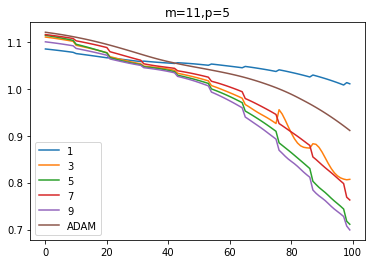

In [122]:
plotr(11,5,l=2)

In [90]:
results[(13,5,5)]

[[1, 0.39250391721725464, 1.0930203199386597, 0.7369835376739502],
 [1, 0.39250391721725464, 1.0922577381134033, 0.7547845840454102],
 [1, 0.39250391721725464, 1.091491460800171, 0.704608678817749],
 [1, 0.39250391721725464, 1.0907065868377686, 0.6589727401733398],
 [1, 0.39250391721725464, 1.0898956060409546, 0.6906471252441406],
 [1, 0.39250391721725464, 1.0890558958053589, 0.6750047206878662],
 [1, 0.39250391721725464, 1.0881853103637695, 0.7839171886444092],
 [1, 0.39250391721725464, 1.0872838497161865, 0.7062983512878418],
 [1, 0.39250391721725464, 1.0863521099090576, 0.6752755641937256],
 [1, 0.39250391721725464, 1.085387110710144, 0.7991368770599365],
 [1, 0.39250391721725464, 1.0843864679336548, 0.7564835548400879],
 [1, 0.39250391721725464, 1.0833474397659302, 0.7662990093231201],
 [0, 0.39250391721725464, 1.0774331092834473, 2.0887134075164795],
 [1, 0.39250391721725464, 1.0762447118759155, 0.6741845607757568],
 [1, 0.39250391721725464, 1.0750213861465454, 0.6826307773590088]

In [104]:
fig, ax = plt.subplots()
i = 0
n=3
keys = []
for key, value in results.items():
    i +=1
    if key[0]==11 and key[1]==7:
        arr = np.array(value)
        ax.plot(arr[:,1],label=key[2])
        
    

ax.legend()
plt.show()
key

(17, 5, 13)

In [123]:
import pickle

with open('results2.db','wb') as db:
    pickle.dump(results, db)

In [82]:
arr = np.array(value)
plt.plot(arr[:,1])

## Single Level Coarsen Train

### with DMD

In [25]:
levels = 1
method = 'NONE'
cratio = .5
TGG_D,_,t = util.geomat_to_multilevel(TGGpm, cratio, method, levels, timing=False)

starting multilevel coarsening...
converted to networkx graph...
perfoming coarsening...
no coarsening...
changing back to pytorch geometric...


In [21]:
start = time.time()
model.reset_parameters()
optimizer = optim.Adam(model.parameters(), lr=.01)
loss_fn = F.nll_loss

results = train_level(model, TGG_D, optimizer,loss_fn, 0, m=5, pred_step=1, r=3,epochs = 20, verbose=False )
end = time.time()
elapsed = end-start

NameError: name 'train_level' is not defined

In [54]:
validate(model, TGG_D[0], loss_fn)

(tensor(0.6701), tensor(0.9138))

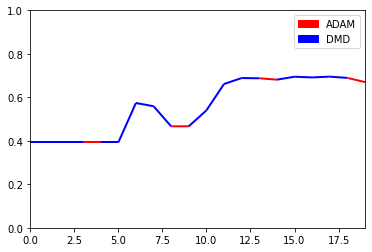

In [55]:
plot_dmd(results)

### no DMD

In [20]:
levels = 4
method = 'ADC'
cratio = .5
TGG_D,_,t = util.geomat_to_multilevel(TGGpm, cratio, method, levels, timing=False)

starting multilevel coarsening...
converted to networkx graph...
perfoming coarsening...
changing back to pytorch geometric...


In [22]:
start = time.time()
model.reset_parameters()
optimizer = optim.Adam(model.parameters(), lr=.001)
loss_fn = F.nll_loss


train_level(model, TGG_D, optimizer,loss_fn, level, epochs = 20, verbose=False )
end = time.time()
elapsed = end-start

NameError: name 'train_level' is not defined

In [28]:
validate(model, TGG_D[0], F.nll_loss), elapsed

(tensor(0.8601), 8.130444765090942)

In [ ]:
no_dmd

## No coarsening

### with DMD

In [62]:
levels = 1
method = 'NONE'
cratio = 1
TGG_D,_,t = util.geomat_to_multilevel(TGGc, cratio, method, levels, timing=False)

starting multilevel coarsening...
converted to networkx graph...
perfoming coarsening...
no coarsening...
changing back to pytorch geometric...


In [45]:
TGG_D

{0: Data(x=[2708, 200], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])}

In [46]:
start = time.time()
model.reset_parameters()
optimizer = optim.Adam(model.parameters(), lr=.001)
loss_fn = F.nll_loss

accuracies = train_level(model, TGG_D, optimizer,loss_fn, 0, m=5, pred_step=1, r=3,epochs=30, verbose=False )
end = time.time()
elapsed = end-start

In [44]:
plot_dmd(accuracies)

In [146]:
plot_dmd(accuracies)

In [136]:
plot_dmd(accuracies)

In [137]:
accs = np.array(accuracies)
dmd_steps = np.where(accs[:,0]==1)[0]

(accs[dmd_steps] - accs[dmd_steps-1])[:,1].mean()

0.006172335147857666

In [142]:
accs = np.array(accuracies)
dmd_steps = np.where(accs[:,0]==0)[0]

(accs[dmd_steps[1:]] - accs[dmd_steps[1:]-1])[:,1].mean()

0.002749581015511845

In [140]:
dmd_steps

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74,
       75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93,
       94, 95, 96, 97, 98], dtype=int64)

### no DMD

In [20]:
levels = 4
method = 'ADC'
cratio = .5
TGG_D,_,t = util.geomat_to_multilevel(TGGpm, cratio, method, levels, timing=False)

starting multilevel coarsening...
converted to networkx graph...
perfoming coarsening...
changing back to pytorch geometric...


In [27]:
start = time.time()
model.reset_parameters()
optimizer = optim.Adam(model.parameters(), lr=.01)
loss_fn = F.nll_loss


for level in range(levels, 0, -1):
        train_level(model, TGG_D, optimizer,loss_fn, level, epochs = 20, verbose=False )
end = time.time()
elapsed = end-start

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
validate(model, TGG_D[0], F.nll_loss), elapsed

(tensor(0.8601), 8.130444765090942)

### With DMD

### No DMD

In [85]:
params = []
for p in model.named_parameters():
    params.append(p)

In [86]:
params[0]

('conv1.bias',
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        requires_grad=True))

### Coarsening and Standard Training

### No Coarsening and DMD Training

### No Coarsening and Standard Training

In [11]:
TGG_D,M,_ = util.geomat_to_multilevel(TGGpm, cratio, method, levels)
lr=1

loss_fn = F.nll_loss
level = 0
m = 20
pred_step = 5
r = 2
epochs = 10

starting multilevel coarsening...
converted to networkx graph...
perfoming coarsening...
ADC: outer loop starting... 
	>> ADC: inner loop time: 2.9416351318359375
	>> ADC: inner loop time: 1.8819150924682617
	>> ADC: inner loop time: 1.0835800170898438


C:\Users\William\Documents\School\Research\spec-coarsening\gnn\matcoarselib.py:220: RuntimeWarning: divide by zero encountered in reciprocal
  row_sums = np.reciprocal(np.array(B.sum(axis=0)).astype(float).flatten())


	>> ADC: inner loop time: 0.6914443969726562
ADC: outer loop time: 6.6298346519470215
ADC: outer loop starting... 
	>> ADC: inner loop time: 0.391772985458374
	>> ADC: inner loop time: 0.34514713287353516
	>> ADC: inner loop time: 0.20398521423339844
	>> ADC: inner loop time: 0.1416478157043457
ADC: outer loop time: 1.0825531482696533
ADC: outer loop starting... 
	>> ADC: inner loop time: 0.09420394897460938
	>> ADC: inner loop time: 0.062499046325683594
	>> ADC: inner loop time: 0.04729723930358887
	>> ADC: inner loop time: 0.031247854232788086
ADC: outer loop time: 0.23524808883666992
ADC: outer loop starting... 
	>> ADC: inner loop time: 0.016037464141845703
	>> ADC: inner loop time: 0.031266212463378906
	>> ADC: inner loop time: 0.01562809944152832
	>> ADC: inner loop time: 0.0156252384185791
	>> ADC: inner loop time: 0.01563858985900879
ADC: outer loop time: 0.09419560432434082
---- IN MULTIMAT COARSEN ----
elapsed coarsen time: 8.198641300201416
changing back to pytorch geometric

In [75]:
model = GNN(num_features, hidden, layers, 3)
optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = F.nll_loss
t = time.time()
train_level(model, TGG_D, optimizer, loss_fn, 0, epochs=31)
time.time()-t, validate(model, TGG_D[0], criterion)

  0%|          | 0/31 [00:00<?, ?it/s]

(15.120712280273438, tensor(0.8538))

In [76]:
model = GNN(num_features, hidden, layers, 3)
optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = F.nll_loss
t = time.time()
train_level(model, TGG_D, optimizer, loss_fn, 0, m=15,r=5, pred_step=10, epochs=15)
train_level(model, TGG_D, optimizer, loss_fn, 0, epochs=13)
time.time()-t, validate(model, TGG_D[0], criterion)

  0%|          | 0/15 [00:00<?, ?it/s]

DMD


  0%|          | 0/6 [00:00<?, ?it/s]

Step 0: 0.012003898620605469
Step 1: 0.15471696853637695
Step 2: 0.0030007362365722656
Step 3: 0.2543764114379883
Step 4: 0.0030028820037841797
Step 5: 0.0010006427764892578


  0%|          | 0/13 [00:00<?, ?it/s]

(16.050039052963257, tensor(0.8469))